# Chilled Water System at UIUC

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

from trends import seasonal_trend, plot_seasonal
# from trends import season_colors as seasons

plt.style.use('ggplot')

## Existing Capacity of Campus Chillers and Their Costs

The data for existing capacity and their associated replacement costs comes from the [UIUC Utilities Production Master Plan](https://fs.illinois.edu/docs/default-source/utilities-energy/utilities-master-plan_.pdf?sfvrsn=16bbfbea_0)

In [2]:
chillers_dict = {'plant':['vet_med', 'chem_life_sciences', 'animal_sciences', 'library', 'north_campus', 'oak_street', 'TES'],
                 'capacity (tons)':[4700,3630,2000, 4300, 16400, 27630, 5000],
                 'replacement cost (M$)':[10.26,7.317,4.435,8.888, 28.688, 51.523, 8.928]}

chiller_lifespan = 25  # approximate value based on master plan document.


chillers_df = pd.DataFrame(chillers_dict)
chillers_df

,plant,capacity (tons),replacement cost (M$)
0,vet_med,4700,10.260
1,chem_life_sciences,3630,7.317
2,animal_sciences,2000,4.435
3,library,4300,8.888
4,north_campus,16400,28.688
5,oak_street,27630,51.523
6,TES,5000,8.928


In [3]:
cws_capacity = chillers_df.loc[0:5]['capacity (tons)'].sum()
print(f"The total capacity of the chillers is {cws_capacity} tons of refrigeration.")

The total capacity of the chillers is 58660 tons of refrigeration.


#### Investment Cost

What is the relationship between replacement cost and capacity?

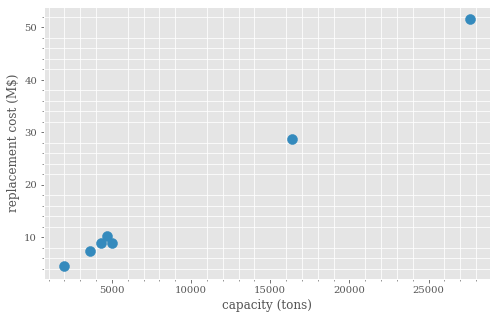

In [4]:
chillers_df.plot(kind='scatter', x='capacity (tons)', y='replacement cost (M$)', figsize=(8,5), s=100)
plt.minorticks_on()
plt.grid(which='minor');plt.grid(which='major')

In [5]:
# cost of a chiller per ton of power
investment_cost = chillers_df.iloc[:-1,2].sum()/cws_capacity  # million dollars per ton
print(f"The investment cost for electric chillers is {round(investment_cost,6)} M$/ton")

The investment cost for electric chillers is 0.001894 M$/ton


In [6]:
tes_investment_cost = chillers_df.iloc[-1:,2].sum()/chillers_df.iloc[-1:,1].sum() 
print(f"The investment cost for thermal storage is {round(tes_investment_cost,6)} M$/ton")

The investment cost for thermal storage is 0.001786 M$/ton


In [7]:
cws_om_costs = np.array([134e3, 275e3,5e3, 68e3, 32e3, 22e3, 55e3, 5e3]).sum()
cws_om_costs = cws_om_costs/chiller_lifespan/cws_capacity/1e6  #M$/ton-year

print(f"The O&M cost for electric chillers is {cws_om_costs} M$/ton-year")

The O&M cost for electric chillers is 4.0640981929764746e-07 M$/ton-year


#### Variable Cost 

The variable cost is based on the non-residential water rate from American Water: Illinois.

The rate is per 100 gallons. For simplicity, I only take the rate of water over 97,240 gallons.

In [8]:
water_price = 0.318/100  # dollars per gallon of water
lbs_per_gallon = 8.33  # pounds in a gallon of water
lbs_per_ton = 2000  # pounds per ton
dollars_per_million = 1e6
gallons_per_hour = 10  # gallons of water moved by 1 ton of refrigeration per hour.


variable_cost = water_price/lbs_per_gallon*lbs_per_ton*gallons_per_hour/dollars_per_million
print(f"The variable cost for electric chillers is {variable_cost} M$/ton-hour")

The variable cost for electric chillers is 7.635054021608644e-06 M$/ton-hour


#### The existing capacity of chillers by installation year.

Data are from the [UIUC Utilities Production Master Plan](https://fs.illinois.edu/docs/default-source/utilities-energy/utilities-master-plan_.pdf?sfvrsn=16bbfbea_0)

In [9]:
capacity_installed = {1997:650,
                      1998:1000+1000,
                      1999:1100,
                      2000:2000+1000,
                      2001:1200+2000+1200+1000+1000+850+850+850,
                      2004:5000+5000+2000,
                      2005:2200,
                      2007:5000,
                      2008:2800,
                      2012:5630+1500,
                      2016:1100+1100,
                      2018:1210*3,
                      2019:1000}
x = list(capacity_installed.keys())
y = np.array(list(capacity_installed.values()))
ycs = y.cumsum()
chillers_build_df = pd.DataFrame({'installed':y,
                                  'capacity':ycs})
for i,j in zip(x,y):
    print(f"{i}, {j}")

1997, 650
1998, 2000
1999, 1100
2000, 3000
2001, 8950
2004, 12000
2005, 2200
2007, 5000
2008, 2800
2012, 7130
2016, 2200
2018, 3630
2019, 1000


#### Calculate the typical "efficiency" of the chillers.

Efficiency is the output/input ratio. In the UIUC Utilities Production Master Plan, the efficiencies are given in 
kw/ton. However, the chillers use electricity and "produce" tons of refrigeration.

Thus we want the inverse of the listed efficiencies.

In addition, I want the activity in terms of millions of tons per GWh. 

Unit for CWS capacity: Tons<br> 
Unit for CWS activity: Millions of Tons

In [10]:
# efficiency is given in kw/ton, I want ton per GW. Data are from table on page 82 of master plan.

efficiencies = np.array([0.637,0.631,0.615,0.580,0.653,0.640,0.640,0.645,0.651,0.676,
                         0.653,0.595,1.2,1.2,0.676,0.676,0.640,0.640,0.640,0.565,0.622,0.634,0.565])
chiller_eff = 1/efficiencies.mean()*1e6/1e6 # million-tons/GW
print(f'Chillers at UIUC produce {chiller_eff} million tons of refrigeration per GWh, on average')

Chillers at UIUC produce 1.4673982391221132 million tons of refrigeration per GWh, on average


## Chilled Water Demand Data

CWS represents the chilled water generated by the chillers. TES represents the amount of chilled water either stored (negative) or extracted (positive).

The total demand of chilled water at any time is given by the sum of CWS + TES.

$$Demand = CWS + TES$$

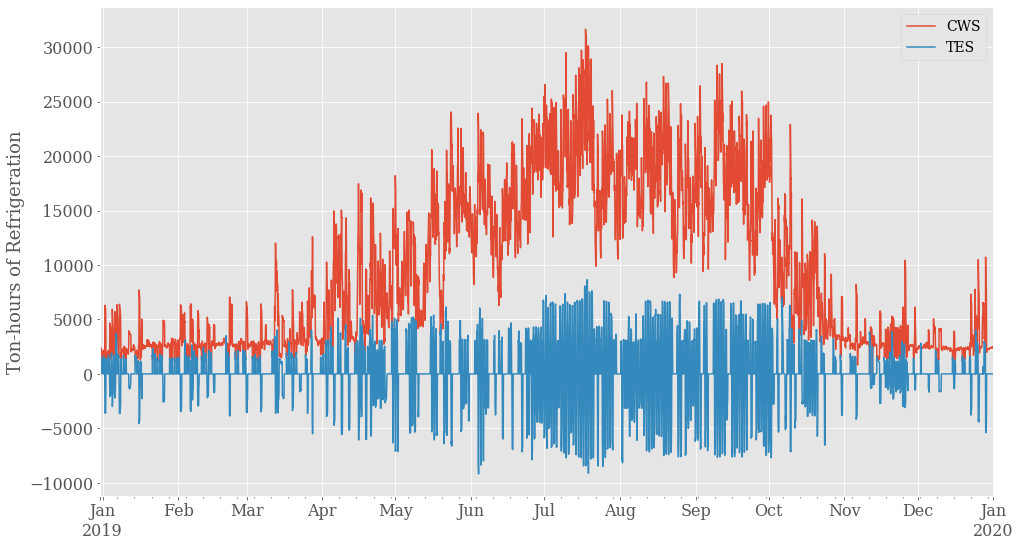

In [11]:
# cws_data = read_csv("../2019energydata.csv", skiprows=1, usecols=['CWS', 'TES'])
cws_data = read_csv("../2019energydata_hourly.csv", usecols=['CWS', 'TES'])
# daterange = pd.date_range(start='12/31/2018', end='1/1/2020', freq='min')
daterange = pd.date_range(start='12/31/2018', end='1/1/2020', freq='H')
cws_data.index = daterange
cws_data_hourly = cws_data.resample('H').mean()
cws_data_hourly.plot(figsize=(16,9))
plt.ylabel('Ton-hours of Refrigeration', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)
plt.show()

In [12]:
# demand sum
total_demand = cws_data_hourly[['CWS','TES']].sum().sum()
print(f"UIUC has a total yearly demand of {total_demand} ton-hours of refrigeration.")

UIUC has a total yearly demand of 83847860.9099162 ton-hours of refrigeration.


In [13]:
cws_data.CWS.sum()/60  # without dividing by 60, this would be ton-minutes rather than ton-hours

1400804.465277777

In [14]:
# ramp_rate = np.array(np.diff(cws_data_hourly.CWS)/cws_data_hourly.CWS[:-1])
cws_ramp_rate = np.array(np.diff(cws_data_hourly.CWS)/np.max(cws_data_hourly.CWS))
print(f"The CWS had a maximum ramp rate of {max(cws_ramp_rate)*100} percent.")

The CWS had a maximum ramp rate of 19.780802192108254 percent.


In [15]:
tes_ramp_rate = np.array(np.diff(cws_data_hourly.TES)/np.max(cws_data_hourly.TES))
print(f"The CWS had a maximum ramp rate of {max(tes_ramp_rate)*100} percent.")

The CWS had a maximum ramp rate of 58.30378022782598 percent.


## Seasonal Average Capacity Factors

This data will indicate how much the technology is actually used around the clock in each season. It will tell Temoa how to use each technology.

In [16]:
cws_seasonal_df = seasonal_trend(cws_data_hourly, 
                             column='CWS',
                             feature='cf', 
                             capacity=chillers_df.loc[0:5]['capacity (tons)'].sum(), )

spring
summer
fall
winter


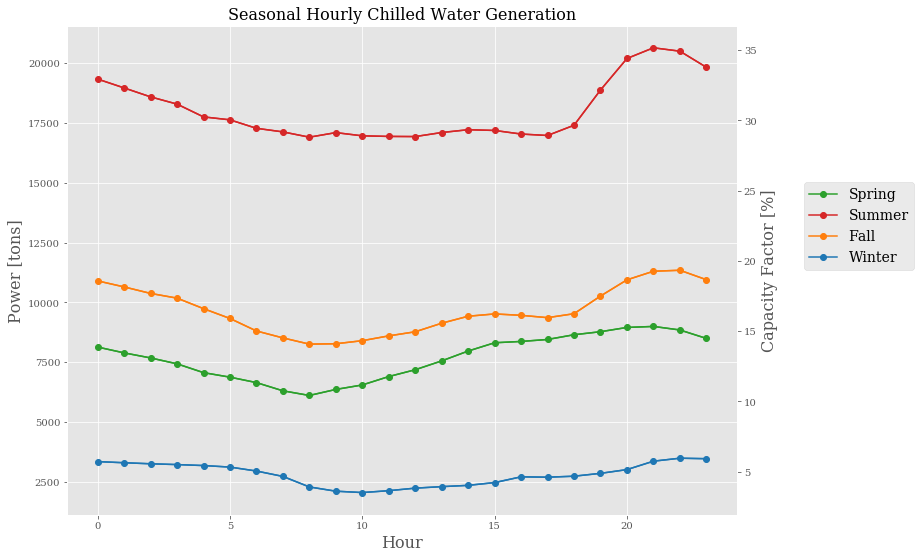

In [17]:
fig, ax = plt.subplots(figsize=(12,9))
colors = {'spring':'tab:green',
          'summer':'tab:red',
          'fall':'tab:orange',
          'winter':'tab:blue'}
ax2 = ax.twinx()
for season in colors:
    print(season)
    cf_key = season+"_cf"
    ax.plot(range(24), cws_seasonal_df[season], label=season.capitalize(), color=colors[season], marker='o')
    ax2.plot(range(24), cws_seasonal_df[cf_key]*100, color=colors[season])
ax.set_xlabel('Hour',fontsize=16)
ax.legend(loc=(1.1,0.5),fontsize=14)
ax.set_ylabel('Power [tons]',fontsize=16)
ax2.set_ylabel('Capacity Factor [%]',fontsize=16)
ax.set_title('Seasonal Hourly Chilled Water Generation',fontsize=16)
plt.grid(which='major')
# fig.savefig("../report/img/cap/seasonal_hourly_cws.png")
plt.show()

In [18]:
tes_seasonal_df = seasonal_trend(cws_data_hourly, 
                             column='TES',
                             feature='cf', 
                             capacity=chillers_df.loc[6]['capacity (tons)'].sum(), )

spring
summer
fall
winter


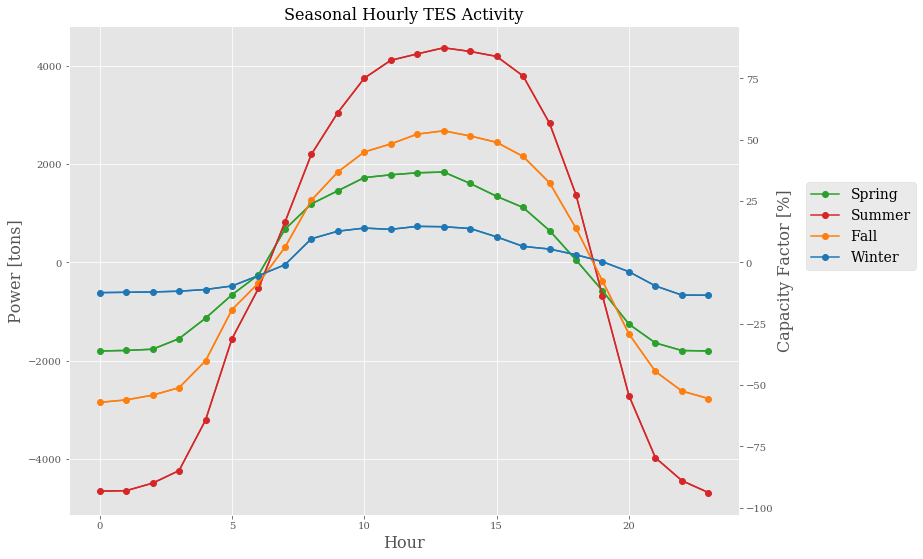

In [19]:
fig, ax = plt.subplots(figsize=(12,9))
colors = {'spring':'tab:green',
          'summer':'tab:red',
          'fall':'tab:orange',
          'winter':'tab:blue'}
ax2 = ax.twinx()
for season in colors:
    print(season)
    cf_key = season+"_cf"
    ax.plot(range(24), tes_seasonal_df[season], label=season.capitalize(), color=colors[season], marker='o')
    ax2.plot(range(24), tes_seasonal_df[cf_key]*100, color=colors[season])
ax.set_xlabel('Hour',fontsize=16)
ax.legend(loc=(1.1,0.5),fontsize=14)
ax.set_ylabel('Power [tons]',fontsize=16)
ax2.set_ylabel('Capacity Factor [%]',fontsize=16)
ax.set_title('Seasonal Hourly TES Activity',fontsize=16)
plt.grid(which='major')
# fig.savefig("../report/img/cap/seasonal_hourly_cws.png")
plt.show()

## Demand specific distribution

Previously, I showed the capacity factor of the chillers for each season. But now I want to know what the annual demand distribution looks like.

In [20]:
spring_mask = (cws_data_hourly.index.month >= 3) & (cws_data_hourly.index.month <= 5)
summer_mask = (cws_data_hourly.index.month >= 6) & (cws_data_hourly.index.month <= 8)
fall_mask = (cws_data_hourly.index.month >= 9) & (cws_data_hourly.index.month <= 11)
winter_mask = ((cws_data_hourly.index.month == 12) | (cws_data_hourly.index.month == 1)
                | (cws_data_hourly.index.month == 2))

seasons = {'spring':spring_mask,
           'summer':summer_mask,
           'fall':fall_mask,
           'winter':winter_mask}

In [21]:
seasonal_hourly_profile = {}
for season in colors:
    mask = seasons[season]
    df = cws_data_hourly[mask]
    hours_grouped = df.groupby(df.index.hour)
    
    avg_hourly = np.zeros(len(hours_grouped))
    std_hourly = np.zeros(len(hours_grouped))
    for i, hour in enumerate(hours_grouped.groups):
        hour_data = hours_grouped.get_group(hour)
        avg_hourly[i] = hour_data.CWS.mean()+hour_data.TES.mean()
        std_hourly[i] = hour_data.CWS.std()+hour_data.TES.std()
        
    seasonal_hourly_profile[season] = avg_hourly
#     print(avg_hourly)
    colname = season+"_dist"
    seasonal_hourly_profile[colname] = avg_hourly/(4*avg_hourly.sum())

In [22]:
distribution_df = pd.DataFrame(seasonal_hourly_profile)

spring
summer
fall
winter


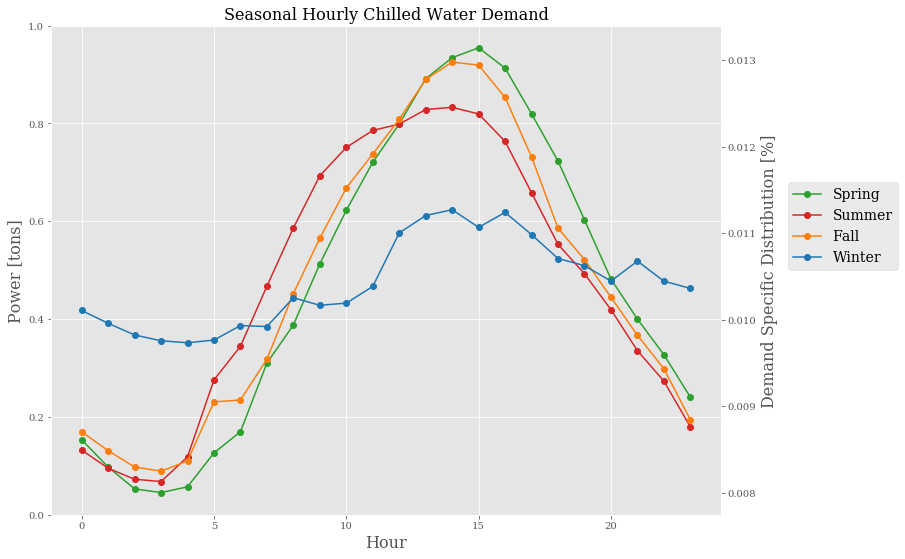

In [23]:
fig, ax = plt.subplots(figsize=(12,9))
colors = {'spring':'tab:green',
          'summer':'tab:red',
          'fall':'tab:orange',
          'winter':'tab:blue'}
ax2 = ax.twinx()
for season in colors:
    print(season)
    cf_key = season+"_dist"
#     ax.plot(range(24), distribution_df[season], label=season.capitalize(), color=colors[season])
    ax2.plot(range(24), distribution_df[cf_key], color=colors[season], marker='o',label=season.capitalize())
ax.set_xlabel('Hour',fontsize=16)
ax2.legend(loc=(1.1,0.5),fontsize=14)
ax.set_ylabel('Power [tons]',fontsize=16)
ax2.set_ylabel('Demand Specific Distribution [%]',fontsize=16)
ax.set_title('Seasonal Hourly Chilled Water Demand',fontsize=16)
plt.grid(which='major')
# fig.savefig("../report/img/cap/seasonal_hourly_cws.png")
plt.show()

In [24]:
total = 0.0
for season in seasons:
    data = distribution_df[season+"_dist"]
    for i,value in enumerate(data):
        total += value
        print(f"INSERT INTO \"DemandSpecificDistribution\" VALUES ('UIUC','{season}','H{i+1}','COOL',{value},'');")

INSERT INTO "DemandSpecificDistribution" VALUES ('UIUC','spring','H1','COOL',0.008612204258677304,'');
INSERT INTO "DemandSpecificDistribution" VALUES ('UIUC','spring','H2','COOL',0.00829607138409125,'');
INSERT INTO "DemandSpecificDistribution" VALUES ('UIUC','spring','H3','COOL',0.008042971070511643,'');
INSERT INTO "DemandSpecificDistribution" VALUES ('UIUC','spring','H4','COOL',0.008000814988230458,'');
INSERT INTO "DemandSpecificDistribution" VALUES ('UIUC','spring','H5','COOL',0.008067120715245945,'');
INSERT INTO "DemandSpecificDistribution" VALUES ('UIUC','spring','H6','COOL',0.008458626676958408,'');
INSERT INTO "DemandSpecificDistribution" VALUES ('UIUC','spring','H7','COOL',0.00870407279758467,'');
INSERT INTO "DemandSpecificDistribution" VALUES ('UIUC','spring','H8','COOL',0.009497077514177856,'');
INSERT INTO "DemandSpecificDistribution" VALUES ('UIUC','spring','H9','COOL',0.009938336386953394,'');
INSERT INTO "DemandSpecificDistribution" VALUES ('UIUC','spring','H10','COO

In [25]:
total

1.0

In [26]:
distribution_df[['fall_dist', 'winter_dist', 'summer_dist', 'spring_dist']].sum()

fall_dist      0.25
winter_dist    0.25
summer_dist    0.25
spring_dist    0.25
dtype: float64

In [27]:
(cws_data_hourly.CWS/cws_data_hourly.CWS.sum()).sum()

1.0

In [28]:
total = 0.0
for season in seasons:
    data = cws_seasonal_df[season+"_cf"]
    for i,value in enumerate(data):
        total += value
        print(f"INSERT INTO `CapacityFactorTech` VALUES ('UIUC','{season}','H{i+1}','CWS',{value},'');")

INSERT INTO `CapacityFactorTech` VALUES ('UIUC','spring','H1','CWS',0.1387019097685471,'');
INSERT INTO `CapacityFactorTech` VALUES ('UIUC','spring','H2','CWS',0.1345612684958036,'');
INSERT INTO `CapacityFactorTech` VALUES ('UIUC','spring','H3','CWS',0.130963712382295,'');
INSERT INTO `CapacityFactorTech` VALUES ('UIUC','spring','H4','CWS',0.12676681375199794,'');
INSERT INTO `CapacityFactorTech` VALUES ('UIUC','spring','H5','CWS',0.12050232594005655,'');
INSERT INTO `CapacityFactorTech` VALUES ('UIUC','spring','H6','CWS',0.11727391318723948,'');
INSERT INTO `CapacityFactorTech` VALUES ('UIUC','spring','H7','CWS',0.11340229909092432,'');
INSERT INTO `CapacityFactorTech` VALUES ('UIUC','spring','H8','CWS',0.10755788572062856,'');
INSERT INTO `CapacityFactorTech` VALUES ('UIUC','spring','H9','CWS',0.1042436216425148,'');
INSERT INTO `CapacityFactorTech` VALUES ('UIUC','spring','H10','CWS',0.10853421182054641,'');
INSERT INTO `CapacityFactorTech` VALUES ('UIUC','spring','H11','CWS',0.111

#### Capacity To Activity

1 ton of refrigeration will generate 8760 ton-hours of refrigeration if operating for an entire year.
This translates to 8760/1e6 million ton-hours.

In [29]:
8760/1e6

0.00876

In [30]:
total_demand/1e6

83.84786090991621

In [31]:
def calculate_capacity_factor():
    
    return

def write_capacity_factor(technology, data, day_slices, year_slices, region):
    """
    This function writes generates the text for the Temoa 'CapacityFactorTech'
    table.
    
    Parameters
    ----------
    technology : string
        The name of the technology in Temoa
        
    data : dictionary or pandas dataframe
        The dictionary containing the data for the capacity factor
    """
     
    pass
        
        
    return 